WANDB LOGS HERE : https://wandb.ai/oopss-moment-iiit-hyderabad/Assignment1_Computer_Vision?nw=nwuseroopssmoment

In [ ]:
pip install wandb scikit-image


In [4]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Get Required Libraries

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import wandb
import cv2
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from skimage.feature import hog


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 4.1.1 Load and preprocess dataset

In [7]:
def load_dataset(file_path):
    data = pd.read_csv(file_path)
    labels = data['label'].values
    images = data.drop(columns=['label']).values.reshape(-1, 28, 28)
    return images, labels

train_images, train_labels = load_dataset("train.csv")
test_images, test_labels = load_dataset("test.csv")

# Split train into train/val
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)


In [8]:
print(f"Number of unique labels in train: {len(np.unique(train_labels))}")
print(f"Number of unique labels in test: {len(np.unique(test_labels))}")

Number of unique labels in train: 10
Number of unique labels in test: 10


In [9]:
# Normalize images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

In [10]:
# print the sizes
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (48000, 28, 28)
Train labels shape: (48000,)
Validation images shape: (12000, 28, 28)
Validation labels shape: (12000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [11]:
def visualize_samples(images, labels, num_samples=12):
    rows = num_samples // 4
    plt.figure(figsize=(15, rows * 5))
    for i in range(num_samples):
        plt.subplot(rows, 4, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(labels[i])
        plt.axis("off")
    plt.show()


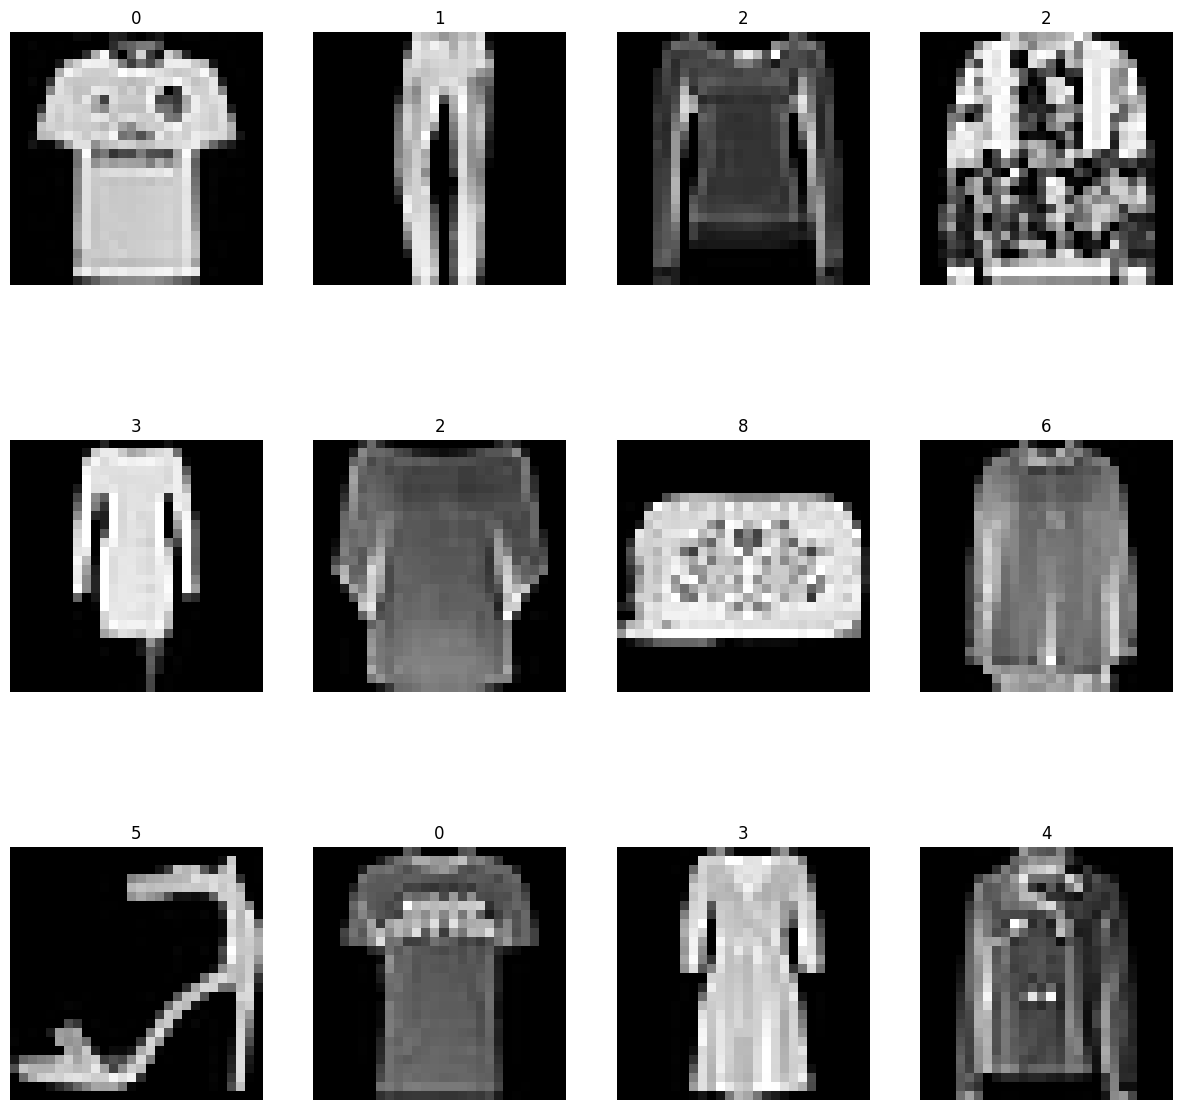

In [12]:
visualize_samples(test_images, test_labels, num_samples=12)

The dataset consists of 10 distinct classes of clothing and accessories.
Each class is assigned a unique numerical label for identification.
The labels are as follows:

0: T-shirt

1: Trouser

2: Pullover

3: Dress

4: Coat

5: Sandal

6: Shirt

7: Sneaker

8: Bag

9: Ankle boot


In [78]:
wandb.init(
            project="Assignment1_Computer_Vision",
            name=f"Initial_Run_Metrics_for_All_Models",
        )

In [14]:
# Store Model Configuration
mlp_config = {
    "input_dim": "input_dim_value",  # Replace with the actual input dimension
    "hidden_layers": [128, 64],
    "activation": "ReLU",
    "dropout": 0.2,
    "output_dim": 10,
    "epochs": 10,
    "batch_size": 64,
    "optimizer": "Adam",
    "learning_rate": 0.001,
    "loss_function": "CrossEntropyLoss",
    "Model 1": "Raw Images",
    "Model 2": "Canny Edge Detection",
    "Model 3": "HOG test Images",
}

wandb.config.update(mlp_config)

In [15]:
# MLP Model Definition
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.model(x)

In [16]:
# Evaluate Function
def evaluate_model(model, loader):
    all_preds, all_labels = [], []
    criterion = nn.CrossEntropyLoss()
    loss=0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    loss/=len(loader)
    return accuracy_score(all_labels, all_preds),loss

In [17]:
def train_model(model, train_loader, val_loader, epochs=30, patience=3, optimizer=None):
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    criterion = nn.CrossEntropyLoss()
    train_loss_array=[]
    val_loss_array=[]
    val_acc_array=[]

    best_acc = 0.0
    patience_counter = 0
    flag=0

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        train_loss = 0.0

        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            if flag==0:
                print(f"Input shape: {images.shape}, Labels shape: {labels.shape}")
                print(f"Output shape: {outputs.shape}")
                flag=1

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_loss_array.append(avg_train_loss)
        print(f"Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_acc,val_loss= evaluate_model(model, val_loader)
        val_loss_array.append(val_loss)
        val_acc_array.append(val_acc)
        print(f"Validation Accuracy: {val_acc:.4f}")



        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            print("Validation accuracy improved. Resetting patience counter.")
        else:
            patience_counter += 1
            print(f"Validation accuracy did not improve. Patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    return model, best_acc ,train_loss_array,val_loss_array,val_acc_array

In [18]:
# Data Preparation
def prepare_dataloader(images, labels, batch_size=64):
    tensor_images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    dataset = TensorDataset(tensor_images, tensor_labels)
    loader = DataLoader(dataset, batch_size=batch_size)
    return loader

def prepare_hog_dataloader(hog_images, labels, batch_size=64):
    tensor_hog_images = torch.tensor(hog_images, dtype=torch.float32)
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    dataset = TensorDataset(tensor_hog_images, tensor_labels)
    loader = DataLoader(dataset, batch_size=batch_size)
    return loader


In [19]:
train_loader = prepare_dataloader(train_images, train_labels)
val_loader = prepare_dataloader(val_images, val_labels)

In [20]:
# print the information about data loader
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    break

Batch of images shape: torch.Size([64, 1, 28, 28])
Batch of labels shape: torch.Size([64])


## MODEL1 1: Raw Pixels

In [21]:
# @title
model1 = MLP(input_dim=28*28).to(device)
model1,model1_acc,_,_,_ = train_model(model1, train_loader, val_loader)


Epoch 1/30


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Input shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 0.6699
Validation Accuracy: 0.8394
Validation accuracy improved. Resetting patience counter.
Epoch 2/30


Train Loss: 0.4532
Validation Accuracy: 0.8585
Validation accuracy improved. Resetting patience counter.
Epoch 3/30


Train Loss: 0.4125
Validation Accuracy: 0.8626
Validation accuracy improved. Resetting patience counter.
Epoch 4/30


Train Loss: 0.3860
Validation Accuracy: 0.8669
Validation accuracy improved. Resetting patience counter.
Epoch 5/30


Train Loss: 0.3714
Validation Accuracy: 0.8752
Validation accuracy improved. Resetting patience counter.
Epoch 6/30


Train Loss: 0.3547
Validation Accuracy: 0.8757
Validation accuracy improved. Resetting patience counter.
Epoch 7/30


Train Loss: 0.3419
Validation Accuracy: 0.8774
Validation accuracy improved. Resetting patience counter.
Epoch 8/30


Train Loss: 0.3331
Validation Accuracy: 0.8774
Validation accuracy did not improve. Patience counter: 1/3
Epoch 9/30


Train Loss: 0.3227
Validation Accuracy: 0.8823
Validation accuracy improved. Resetting patience counter.
Epoch 10/30


Train Loss: 0.3158
Validation Accuracy: 0.8835
Validation accuracy improved. Resetting patience counter.
Epoch 11/30


Train Loss: 0.3086
Validation Accuracy: 0.8841
Validation accuracy improved. Resetting patience counter.
Epoch 12/30


Train Loss: 0.2993
Validation Accuracy: 0.8872
Validation accuracy improved. Resetting patience counter.
Epoch 13/30


Train Loss: 0.2950
Validation Accuracy: 0.8842
Validation accuracy did not improve. Patience counter: 1/3
Epoch 14/30


Train Loss: 0.2886
Validation Accuracy: 0.8848
Validation accuracy did not improve. Patience counter: 2/3
Epoch 15/30


Train Loss: 0.2843
Validation Accuracy: 0.8882
Validation accuracy improved. Resetting patience counter.
Epoch 16/30


Train Loss: 0.2801
Validation Accuracy: 0.8864
Validation accuracy did not improve. Patience counter: 1/3
Epoch 17/30


Train Loss: 0.2768
Validation Accuracy: 0.8899
Validation accuracy improved. Resetting patience counter.
Epoch 18/30


Train Loss: 0.2705
Validation Accuracy: 0.8883
Validation accuracy did not improve. Patience counter: 1/3
Epoch 19/30


Train Loss: 0.2698
Validation Accuracy: 0.8880
Validation accuracy did not improve. Patience counter: 2/3
Epoch 20/30


Train Loss: 0.2637
Validation Accuracy: 0.8901
Validation accuracy improved. Resetting patience counter.
Epoch 21/30


Train Loss: 0.2590
Validation Accuracy: 0.8922
Validation accuracy improved. Resetting patience counter.
Epoch 22/30


Train Loss: 0.2559
Validation Accuracy: 0.8907
Validation accuracy did not improve. Patience counter: 1/3
Epoch 23/30


Train Loss: 0.2549
Validation Accuracy: 0.8922
Validation accuracy did not improve. Patience counter: 2/3
Epoch 24/30


Train Loss: 0.2478
Validation Accuracy: 0.8928
Validation accuracy improved. Resetting patience counter.
Epoch 25/30


Train Loss: 0.2476
Validation Accuracy: 0.8922
Validation accuracy did not improve. Patience counter: 1/3
Epoch 26/30


Train Loss: 0.2424
Validation Accuracy: 0.8916
Validation accuracy did not improve. Patience counter: 2/3
Epoch 27/30


Train Loss: 0.2393
Validation Accuracy: 0.8904
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.8928


## Model 2: Edge Detection


In [22]:
def edge_detection(images):
    return np.array([cv2.Canny((img*255).astype(np.uint8), 100, 200) for img in images])

In [23]:
edge_train_images = edge_detection(train_images)
edge_val_images = edge_detection(val_images)

edge_train_loader = prepare_dataloader(edge_train_images, train_labels)
edge_val_loader = prepare_dataloader(edge_val_images, val_labels)

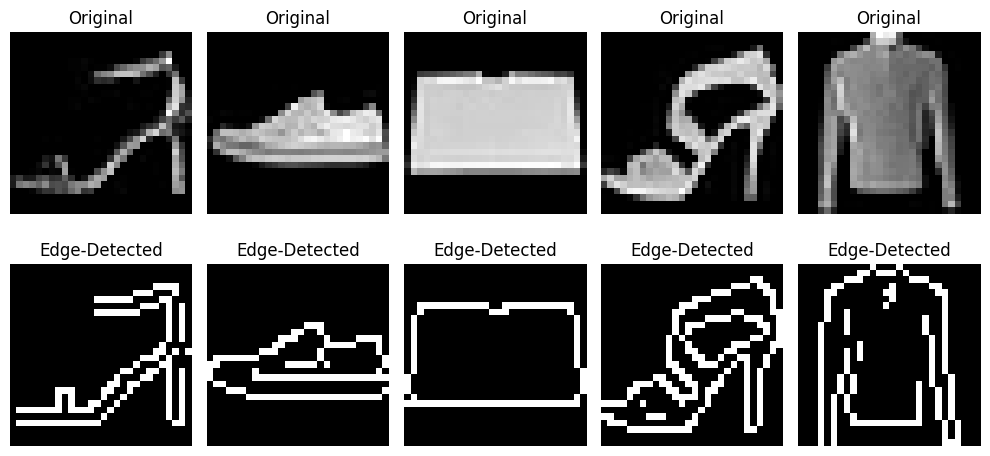

In [24]:
def visualize_edge_detection(original_images, edge_images, num_samples=5):
    """
    Visualize original images and their edge-detected versions side by side.

    Args:
        original_images (np.ndarray): Array of original images.
        edge_images (np.ndarray): Array of edge-detected images.
        num_samples (int): Number of samples to display (default is 5).
    """
    plt.figure(figsize=(10, 5))

    for i in range(num_samples):
        # Original image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Edge-detected image
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(edge_images[i], cmap='gray')
        plt.title("Edge-Detected")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Visualize the first 5 images and their edge-detected counterparts
visualize_edge_detection(train_images[:5], edge_train_images[:5], num_samples=5)

In [45]:
model2 = MLP(input_dim=28*28).to(device)
model2,model2_acc,model2_train_loss, model2_val_loss, model2_val_acc= train_model(model2, edge_train_loader, edge_val_loader)


Epoch 1/30


Training:   2%|▏         | 14/750 [00:00<00:05, 128.11it/s]

Input shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 1.0108
Validation Accuracy: 0.7883
Validation accuracy improved. Resetting patience counter.
Epoch 2/30


Train Loss: 0.6003
Validation Accuracy: 0.8102
Validation accuracy improved. Resetting patience counter.
Epoch 3/30


Train Loss: 0.5195
Validation Accuracy: 0.8258
Validation accuracy improved. Resetting patience counter.
Epoch 4/30


Train Loss: 0.4895
Validation Accuracy: 0.8276
Validation accuracy improved. Resetting patience counter.
Epoch 5/30


Train Loss: 0.4570
Validation Accuracy: 0.8367
Validation accuracy improved. Resetting patience counter.
Epoch 6/30


Train Loss: 0.4402
Validation Accuracy: 0.8390
Validation accuracy improved. Resetting patience counter.
Epoch 7/30


Train Loss: 0.4244
Validation Accuracy: 0.8353
Validation accuracy did not improve. Patience counter: 1/3
Epoch 8/30


Train Loss: 0.4123
Validation Accuracy: 0.8419
Validation accuracy improved. Resetting patience counter.
Epoch 9/30


Train Loss: 0.4019
Validation Accuracy: 0.8397
Validation accuracy did not improve. Patience counter: 1/3
Epoch 10/30


Train Loss: 0.3938
Validation Accuracy: 0.8352
Validation accuracy did not improve. Patience counter: 2/3
Epoch 11/30


Train Loss: 0.3870
Validation Accuracy: 0.8337
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.8419


## Model 3: Custom Feature Extraction (HOG)


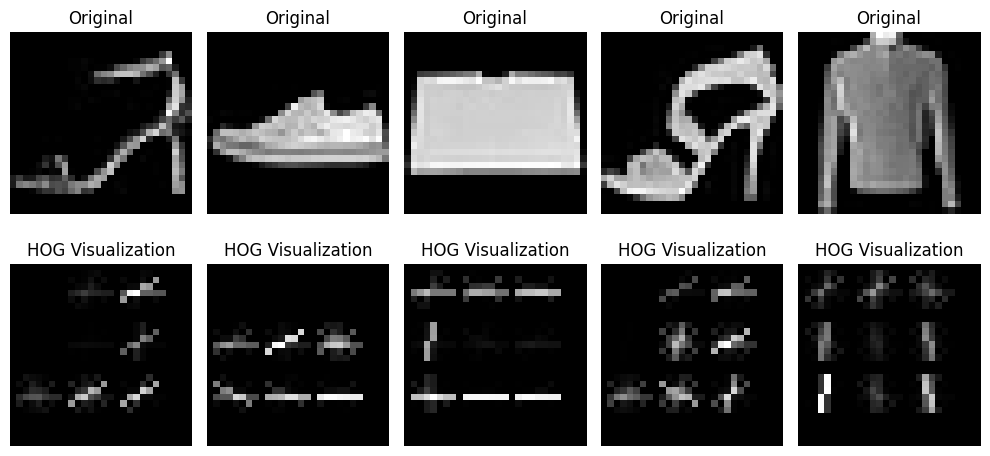

In [26]:
def visualize_hog_features(images, num_samples=5):
    """
    Visualize original images and their HOG feature visualizations side by side.

    Args:
        images (np.ndarray): Array of original images.
        num_samples (int): Number of samples to visualize (default is 5).
    """
    plt.figure(figsize=(10, 5))

    for i in range(num_samples):
        # Original image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # HOG visualization
        _, hog_image = hog(images[i], orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(hog_image, cmap='gray')
        plt.title("HOG Visualization")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize HOG features for the first 5 training images
visualize_hog_features(train_images[:5], num_samples=5)

In [27]:
def extract_hog_features(images):
    features = []
    for img in images:
        hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
        features.append(hog_feat)
    return np.array(features)

hog_train_images = extract_hog_features(train_images)
hog_val_images = extract_hog_features(val_images)

hog_train_loader = prepare_hog_dataloader(hog_train_images, train_labels)
hog_val_loader = prepare_hog_dataloader(hog_val_images, val_labels)

model3 = MLP(input_dim=hog_train_images.shape[1]).to(device)
model3,model3_acc,_,_,_ = train_model(model3, hog_train_loader, hog_val_loader)

Epoch 1/30


Training:   7%|▋         | 50/750 [00:00<00:01, 496.57it/s]

Input shape: torch.Size([64, 144]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 0.8766
Validation Accuracy: 0.7756
Validation accuracy improved. Resetting patience counter.
Epoch 2/30


Train Loss: 0.5958
Validation Accuracy: 0.7961
Validation accuracy improved. Resetting patience counter.
Epoch 3/30


Train Loss: 0.5491
Validation Accuracy: 0.8079
Validation accuracy improved. Resetting patience counter.
Epoch 4/30


Train Loss: 0.5219
Validation Accuracy: 0.8135
Validation accuracy improved. Resetting patience counter.
Epoch 5/30


Train Loss: 0.5040
Validation Accuracy: 0.8177
Validation accuracy improved. Resetting patience counter.
Epoch 6/30


Train Loss: 0.4889
Validation Accuracy: 0.8203
Validation accuracy improved. Resetting patience counter.
Epoch 7/30


Train Loss: 0.4742
Validation Accuracy: 0.8242
Validation accuracy improved. Resetting patience counter.
Epoch 8/30


Train Loss: 0.4630
Validation Accuracy: 0.8269
Validation accuracy improved. Resetting patience counter.
Epoch 9/30


Train Loss: 0.4543
Validation Accuracy: 0.8269
Validation accuracy did not improve. Patience counter: 1/3
Epoch 10/30


Train Loss: 0.4484
Validation Accuracy: 0.8316
Validation accuracy improved. Resetting patience counter.
Epoch 11/30


Train Loss: 0.4421
Validation Accuracy: 0.8321
Validation accuracy improved. Resetting patience counter.
Epoch 12/30


Train Loss: 0.4345
Validation Accuracy: 0.8320
Validation accuracy did not improve. Patience counter: 1/3
Epoch 13/30


Train Loss: 0.4297
Validation Accuracy: 0.8369
Validation accuracy improved. Resetting patience counter.
Epoch 14/30


Train Loss: 0.4231
Validation Accuracy: 0.8365
Validation accuracy did not improve. Patience counter: 1/3
Epoch 15/30


Train Loss: 0.4196
Validation Accuracy: 0.8383
Validation accuracy improved. Resetting patience counter.
Epoch 16/30


Train Loss: 0.4138
Validation Accuracy: 0.8403
Validation accuracy improved. Resetting patience counter.
Epoch 17/30


Train Loss: 0.4109
Validation Accuracy: 0.8386
Validation accuracy did not improve. Patience counter: 1/3
Epoch 18/30


Train Loss: 0.4062
Validation Accuracy: 0.8393
Validation accuracy did not improve. Patience counter: 2/3
Epoch 19/30


Train Loss: 0.4026
Validation Accuracy: 0.8417
Validation accuracy improved. Resetting patience counter.
Epoch 20/30


Train Loss: 0.3988
Validation Accuracy: 0.8410
Validation accuracy did not improve. Patience counter: 1/3
Epoch 21/30


Train Loss: 0.3939
Validation Accuracy: 0.8439
Validation accuracy improved. Resetting patience counter.
Epoch 22/30


Train Loss: 0.3919
Validation Accuracy: 0.8455
Validation accuracy improved. Resetting patience counter.
Epoch 23/30


Train Loss: 0.3877
Validation Accuracy: 0.8397
Validation accuracy did not improve. Patience counter: 1/3
Epoch 24/30


Train Loss: 0.3887
Validation Accuracy: 0.8459
Validation accuracy improved. Resetting patience counter.
Epoch 25/30


Train Loss: 0.3849
Validation Accuracy: 0.8439
Validation accuracy did not improve. Patience counter: 1/3
Epoch 26/30


Train Loss: 0.3808
Validation Accuracy: 0.8449
Validation accuracy did not improve. Patience counter: 2/3
Epoch 27/30


Train Loss: 0.3775
Validation Accuracy: 0.8443
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.8459


In [79]:
# Evaluation Metrics
def evaluate_metrics(model, loader):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1, "confusion_matrix": cm}

# Main Evaluation Function
def evaluate_models(models, loaders):
    metrics = []
    for i, (model, loader) in enumerate(zip(models, loaders)):
        model_metrics = evaluate_metrics(model, loader)
        metrics.append(model_metrics)
        wandb.log({f"Model_{i+1}_metrics": model_metrics})
        print(f"Metrics for Model {i+1}: {model_metrics}")

    wandb.finish()
    return metrics


canny_test_images=edge_detection(test_images)
hog_test_images=extract_hog_features(test_images)
test_loader = prepare_dataloader(test_images, test_labels)
canny_test_loader = prepare_dataloader(canny_test_images, test_labels)
hog_test_loader = prepare_hog_dataloader(hog_test_images, test_labels)

# Evaluate Models
metrics = evaluate_models([model1, model2, model3], [test_loader, canny_test_loader, hog_test_loader])


Metrics for Model 1: {'accuracy': 0.8846, 'precision': 0.8844781655573325, 'recall': 0.8846, 'f1': 0.8830550159295502, 'confusion_matrix': array([[857,   0,   9,  32,   0,   2,  87,   0,  13,   0],
       [  3, 981,   1,  11,   0,   0,   3,   0,   1,   0],
       [ 14,   0, 754,  12, 159,   0,  60,   0,   1,   0],
       [ 24,  14,   9, 911,  25,   1,  14,   0,   2,   0],
       [  0,   0,  40,  26, 889,   0,  41,   0,   4,   0],
       [  0,   0,   0,   0,   0, 950,   0,  33,   4,  13],
       [183,   2,  68,  24,  82,   0, 626,   0,  15,   0],
       [  0,   0,   0,   0,   0,  23,   0, 938,   0,  39],
       [  1,   0,   4,   3,   4,   1,   1,   2, 984,   0],
       [  0,   0,   0,   0,   0,  10,   0,  34,   0, 956]])}
Metrics for Model 2: {'accuracy': 0.8379, 'precision': 0.8417651051757543, 'recall': 0.8379000000000001, 'f1': 0.8359745955728972, 'confusion_matrix': array([[796,  13,   7,  65,   4,   0, 102,   0,  13,   0],
       [  1, 959,   1,  23,   4,   1,  11,   0,   0,   0],


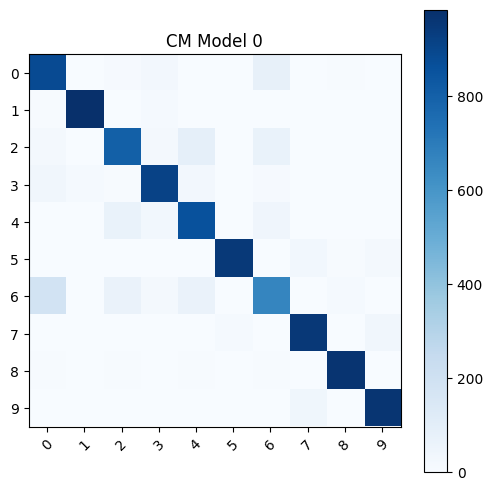

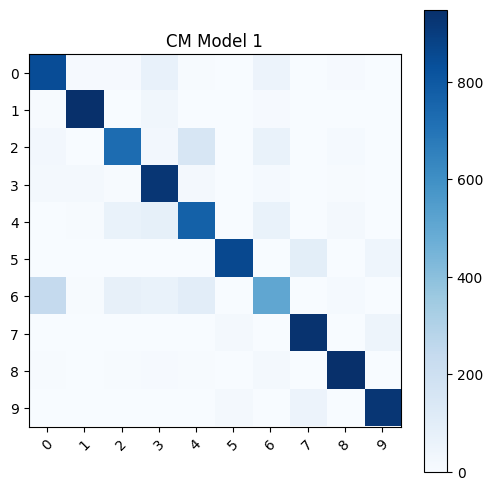

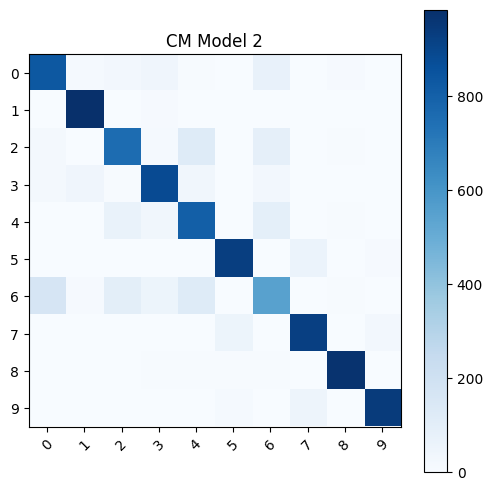

In [29]:
def plot_confusion_matrix(cm, class_names, model_number):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"CM Model {model_number}") # Add title with model number
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.show()

# Now when you call the function, pass the model number:
plot_confusion_matrix(metrics[0]["confusion_matrix"], class_names=range(10), model_number=0)
plot_confusion_matrix(metrics[1]["confusion_matrix"], class_names=range(10), model_number=1)
plot_confusion_matrix(metrics[2]["confusion_matrix"], class_names=range(10), model_number=2)

[LOGS OF WANDB HERE](https://wandb.ai/oopss-moment-iiit-hyderabad/Assignment1_CV/runs/2hoscbyg/overview)

# SECTION 4.3 Plots and Performance Visualizations

In [31]:
def train_multiple_variants(model_name,train_loader, val_loader, input_dim, variants):
    best_model = None
    best_acc = -1
    best_metrics = {"train_loss": [], "val_loss": [], "val_acc": []}

    for i, variant in enumerate(variants):
        # Initialize WandB for this variant
        wandb.init(
            project="Assignment1_Computer_Vision",
            name=f"Task-4.3_{model_name}_lr_{variant['lr']}_opt_{variant['optimizer']}",
            config=variant
        )

        print(f"Training Model Variant {i + 1} with params: {variant}")
        model = MLP(input_dim=input_dim).to(device)

        # Choose optimizer
        if variant["optimizer"] == "adam":
            optimizer = optim.Adam(model.parameters(), lr=variant["lr"])
        elif variant["optimizer"] == "sgd":
            optimizer = optim.SGD(model.parameters(), lr=variant["lr"], momentum=0.9)
        else:
            raise ValueError(f"Unsupported optimizer: {variant['optimizer']}")

        # Train the model and log metrics
        model, acc, train_loss, val_loss, val_acc = train_model(
            model,
            train_loader,
            val_loader,
            epochs=variant["epochs"],
            patience=variant["patience"],
            optimizer=optimizer,
        )

        # Log final metrics to WandB
        wandb.log({
            "final_validation_accuracy": acc,
            "final_train_loss": train_loss[-1] if train_loss else None,
            "final_val_loss": val_loss[-1] if val_loss else None,
        })

        # Log training/validation curves
        for epoch, (t_loss, v_loss, v_acc) in enumerate(zip(train_loss, val_loss, val_acc)):
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": t_loss,
                "val_loss": v_loss,
                "val_accuracy": v_acc,
            })

        # Update the best model based on validation accuracy
        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_metrics = {"train_loss": train_loss, "val_loss": val_loss, "val_acc": val_acc}

        # Finish the current WandB run
        wandb.finish()

    return best_model, best_acc, best_metrics["train_loss"], best_metrics["val_loss"], best_metrics["val_acc"]

In [32]:
# Variants
variants = [
    {"lr": 0.1, "optimizer": "adam", "epochs": 20, "patience": 3},
    {"lr": 0.1, "optimizer": "sgd", "epochs": 20, "patience": 3},
    {"lr": 0.01, "optimizer": "adam", "epochs": 20, "patience": 3},
    {"lr": 0.01, "optimizer": "sgd", "epochs": 20, "patience": 3},
]

In [33]:
model1,model1_acc,model1_train_loss,model1_val_loss,model1_val_acc = train_multiple_variants("Raw",train_loader, val_loader, 28*28, variants)

Training Model Variant 1 with params: {'lr': 0.1, 'optimizer': 'adam', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   6%|▌         | 46/750 [00:00<00:01, 457.63it/s]

Input shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 2.3838
Validation Accuracy: 0.1027
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 2.3115
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 1/3
Epoch 3/20


Train Loss: 2.3116
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 2/3
Epoch 4/20


Train Loss: 2.3117
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.1027


epoch,▁▃▆█
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,█▁▁▁
val_accuracy,▁▁▁▁
val_loss,▁▆▇█
epoch,4
final_train_loss,2.31168
final_val_loss,2.30586
final_validation_accuracy,0.10267


Training Model Variant 2 with params: {'lr': 0.1, 'optimizer': 'sgd', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   4%|▍         | 29/750 [00:00<00:02, 288.23it/s]

Input shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 0.7839
Validation Accuracy: 0.7526
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 0.6400
Validation Accuracy: 0.8178
Validation accuracy improved. Resetting patience counter.
Epoch 3/20


Train Loss: 0.6135
Validation Accuracy: 0.8066
Validation accuracy did not improve. Patience counter: 1/3
Epoch 4/20


Train Loss: 0.6195
Validation Accuracy: 0.8258
Validation accuracy improved. Resetting patience counter.
Epoch 5/20


Train Loss: 0.5887
Validation Accuracy: 0.8216
Validation accuracy did not improve. Patience counter: 1/3
Epoch 6/20


Train Loss: 0.5986
Validation Accuracy: 0.8237
Validation accuracy did not improve. Patience counter: 2/3
Epoch 7/20


Train Loss: 0.6031
Validation Accuracy: 0.8073
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.8258


epoch,▁▂▃▅▆▇█
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,█▃▂▂▁▁▂
val_accuracy,▁▇▆███▆
val_loss,█▃▃▁▁▃▃
epoch,7
final_train_loss,0.60307
final_val_loss,0.5298
final_validation_accuracy,0.82583


Training Model Variant 3 with params: {'lr': 0.01, 'optimizer': 'adam', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   4%|▍         | 30/750 [00:00<00:02, 295.36it/s]

Input shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 0.6733
Validation Accuracy: 0.8224
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 0.5736
Validation Accuracy: 0.8271
Validation accuracy improved. Resetting patience counter.
Epoch 3/20


Train Loss: 0.5504
Validation Accuracy: 0.8217
Validation accuracy did not improve. Patience counter: 1/3
Epoch 4/20


Train Loss: 0.5389
Validation Accuracy: 0.8406
Validation accuracy improved. Resetting patience counter.
Epoch 5/20


Train Loss: 0.5409
Validation Accuracy: 0.8299
Validation accuracy did not improve. Patience counter: 1/3
Epoch 6/20


Train Loss: 0.5232
Validation Accuracy: 0.8343
Validation accuracy did not improve. Patience counter: 2/3
Epoch 7/20


Train Loss: 0.5090
Validation Accuracy: 0.8413
Validation accuracy improved. Resetting patience counter.
Epoch 8/20


Train Loss: 0.5022
Validation Accuracy: 0.8363
Validation accuracy did not improve. Patience counter: 1/3
Epoch 9/20


Train Loss: 0.5157
Validation Accuracy: 0.8254
Validation accuracy did not improve. Patience counter: 2/3
Epoch 10/20


Train Loss: 0.5036
Validation Accuracy: 0.8399
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.8413


epoch,▁▂▃▃▄▅▆▆▇█
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,█▄▃▂▃▂▁▁▂▁
val_accuracy,▁▃▁█▄▅█▆▂█
val_loss,█▄▄▃▄▅▁▃█▅
epoch,10
final_train_loss,0.50359
final_val_loss,0.47608
final_validation_accuracy,0.84125


Training Model Variant 4 with params: {'lr': 0.01, 'optimizer': 'sgd', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   5%|▍         | 35/750 [00:00<00:02, 344.06it/s]

Input shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 0.8430
Validation Accuracy: 0.8046
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 0.5120
Validation Accuracy: 0.8420
Validation accuracy improved. Resetting patience counter.
Epoch 3/20


Train Loss: 0.4560
Validation Accuracy: 0.8533
Validation accuracy improved. Resetting patience counter.
Epoch 4/20


Train Loss: 0.4224
Validation Accuracy: 0.8565
Validation accuracy improved. Resetting patience counter.
Epoch 5/20


Train Loss: 0.4036
Validation Accuracy: 0.8683
Validation accuracy improved. Resetting patience counter.
Epoch 6/20


Train Loss: 0.3873
Validation Accuracy: 0.8725
Validation accuracy improved. Resetting patience counter.
Epoch 7/20


Train Loss: 0.3748
Validation Accuracy: 0.8755
Validation accuracy improved. Resetting patience counter.
Epoch 8/20


Train Loss: 0.3661
Validation Accuracy: 0.8747
Validation accuracy did not improve. Patience counter: 1/3
Epoch 9/20


Train Loss: 0.3540
Validation Accuracy: 0.8777
Validation accuracy improved. Resetting patience counter.
Epoch 10/20


Train Loss: 0.3441
Validation Accuracy: 0.8795
Validation accuracy improved. Resetting patience counter.
Epoch 11/20


Train Loss: 0.3363
Validation Accuracy: 0.8779
Validation accuracy did not improve. Patience counter: 1/3
Epoch 12/20


Train Loss: 0.3280
Validation Accuracy: 0.8827
Validation accuracy improved. Resetting patience counter.
Epoch 13/20


Train Loss: 0.3224
Validation Accuracy: 0.8821
Validation accuracy did not improve. Patience counter: 1/3
Epoch 14/20


Train Loss: 0.3171
Validation Accuracy: 0.8842
Validation accuracy improved. Resetting patience counter.
Epoch 15/20


Train Loss: 0.3121
Validation Accuracy: 0.8845
Validation accuracy improved. Resetting patience counter.
Epoch 16/20


Train Loss: 0.3078
Validation Accuracy: 0.8841
Validation accuracy did not improve. Patience counter: 1/3
Epoch 17/20


Train Loss: 0.3007
Validation Accuracy: 0.8838
Validation accuracy did not improve. Patience counter: 2/3
Epoch 18/20


Train Loss: 0.2987
Validation Accuracy: 0.8831
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.8845


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇█▇███████
val_loss,█▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,18
final_train_loss,0.29873
final_val_loss,0.31739
final_validation_accuracy,0.8845


In [34]:
model2,model2_acc,model2_train_loss,model2_val_loss,model2_val_acc = train_multiple_variants("canny_edge",edge_train_loader, edge_val_loader, 28*28, variants)

Training Model Variant 1 with params: {'lr': 0.1, 'optimizer': 'adam', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   4%|▍         | 31/750 [00:00<00:02, 305.01it/s]

Input shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 12.9878
Validation Accuracy: 0.1027
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 2.3121
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 1/3
Epoch 3/20


Train Loss: 2.3117
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 2/3
Epoch 4/20


Train Loss: 2.3117
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.1027


epoch,▁▃▆█
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,█▁▁▁
val_accuracy,▁▁▁▁
val_loss,▁▆▇█
epoch,4
final_train_loss,2.31169
final_val_loss,2.30589
final_validation_accuracy,0.10267


Training Model Variant 2 with params: {'lr': 0.1, 'optimizer': 'sgd', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   6%|▌         | 46/750 [00:00<00:01, 458.08it/s]

Input shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 4761132.7267
Validation Accuracy: 0.1027
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 22.9589
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 1/3
Epoch 3/20


Train Loss: 2.3059
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 2/3
Epoch 4/20


Train Loss: 2.3059
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.1027


epoch,▁▃▆█
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,█▁▁▁
val_accuracy,▁▁▁▁
val_loss,▆█▁█
epoch,4
final_train_loss,2.30592
final_val_loss,2.30358
final_validation_accuracy,0.10267


Training Model Variant 3 with params: {'lr': 0.01, 'optimizer': 'adam', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   6%|▌         | 44/750 [00:00<00:01, 435.33it/s]

Input shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 2.1437
Validation Accuracy: 0.3507
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 1.9574
Validation Accuracy: 0.3379
Validation accuracy did not improve. Patience counter: 1/3
Epoch 3/20


Train Loss: 1.7264
Validation Accuracy: 0.3821
Validation accuracy improved. Resetting patience counter.
Epoch 4/20


Train Loss: 1.7623
Validation Accuracy: 0.3235
Validation accuracy did not improve. Patience counter: 1/3
Epoch 5/20


Train Loss: 1.7670
Validation Accuracy: 0.2973
Validation accuracy did not improve. Patience counter: 2/3
Epoch 6/20


Train Loss: 1.7667
Validation Accuracy: 0.3500
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.3821


epoch,▁▂▄▅▇█
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,█▅▁▂▂▂
val_accuracy,▅▄█▃▁▅
val_loss,▇▆▁▅█▃
epoch,6
final_train_loss,1.76671
final_val_loss,1.58157
final_validation_accuracy,0.38208


Training Model Variant 4 with params: {'lr': 0.01, 'optimizer': 'sgd', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   7%|▋         | 50/750 [00:00<00:01, 494.98it/s]

Input shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 2.4550
Validation Accuracy: 0.1027
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 2.3162
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 1/3
Epoch 3/20


Train Loss: 2.3055
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 2/3
Epoch 4/20


Train Loss: 2.3060
Validation Accuracy: 0.1027
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.1027


epoch,▁▃▆█
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,█▂▁▁
val_accuracy,▁▁▁▁
val_loss,▃▆█▁
epoch,4
final_train_loss,2.30598
final_val_loss,2.30257
final_validation_accuracy,0.10267


In [35]:
model3,model3_acc,model3_train_loss,model3_val_loss,model3_val_acc = train_multiple_variants("HOG",hog_train_loader, hog_val_loader, hog_train_images.shape[1], variants)

Training Model Variant 1 with params: {'lr': 0.1, 'optimizer': 'adam', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   6%|▋         | 48/750 [00:00<00:01, 476.59it/s]

Input shape: torch.Size([64, 144]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 1.2307
Validation Accuracy: 0.6527
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 1.3096
Validation Accuracy: 0.6038
Validation accuracy did not improve. Patience counter: 1/3
Epoch 3/20


Train Loss: 1.4650
Validation Accuracy: 0.3959
Validation accuracy did not improve. Patience counter: 2/3
Epoch 4/20


Train Loss: 1.5148
Validation Accuracy: 0.4266
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.6527


epoch,▁▃▆█
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,▁▃▇█
val_accuracy,█▇▁▂
val_loss,▁▂█▆
epoch,4
final_train_loss,1.51482
final_val_loss,1.34267
final_validation_accuracy,0.65267


Training Model Variant 2 with params: {'lr': 0.1, 'optimizer': 'sgd', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   7%|▋         | 55/750 [00:00<00:01, 542.27it/s]

Input shape: torch.Size([64, 144]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 0.8099
Validation Accuracy: 0.7927
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 0.5794
Validation Accuracy: 0.8113
Validation accuracy improved. Resetting patience counter.
Epoch 3/20


Train Loss: 0.5469
Validation Accuracy: 0.8017
Validation accuracy did not improve. Patience counter: 1/3
Epoch 4/20


Train Loss: 0.5279
Validation Accuracy: 0.8215
Validation accuracy improved. Resetting patience counter.
Epoch 5/20


Train Loss: 0.5129
Validation Accuracy: 0.8190
Validation accuracy did not improve. Patience counter: 1/3
Epoch 6/20


Train Loss: 0.4994
Validation Accuracy: 0.8213
Validation accuracy did not improve. Patience counter: 2/3
Epoch 7/20


Train Loss: 0.4917
Validation Accuracy: 0.8273
Validation accuracy improved. Resetting patience counter.
Epoch 8/20


Train Loss: 0.4840
Validation Accuracy: 0.8223
Validation accuracy did not improve. Patience counter: 1/3
Epoch 9/20


Train Loss: 0.4790
Validation Accuracy: 0.8270
Validation accuracy did not improve. Patience counter: 2/3
Epoch 10/20


Train Loss: 0.4745
Validation Accuracy: 0.8283
Validation accuracy improved. Resetting patience counter.
Epoch 11/20


Train Loss: 0.4698
Validation Accuracy: 0.8272
Validation accuracy did not improve. Patience counter: 1/3
Epoch 12/20


Train Loss: 0.4615
Validation Accuracy: 0.8197
Validation accuracy did not improve. Patience counter: 2/3
Epoch 13/20


Train Loss: 0.4599
Validation Accuracy: 0.8271
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.8283


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▅▃▇▆▇█▇███▆█
val_loss,█▅▅▃▂▂▁▂▁▁▁▂▁
epoch,13
final_train_loss,0.45993
final_val_loss,0.44722
final_validation_accuracy,0.82825


Training Model Variant 3 with params: {'lr': 0.01, 'optimizer': 'adam', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   7%|▋         | 50/750 [00:00<00:01, 498.93it/s]

Input shape: torch.Size([64, 144]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 0.6810
Validation Accuracy: 0.8057
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 0.5563
Validation Accuracy: 0.8131
Validation accuracy improved. Resetting patience counter.
Epoch 3/20


Train Loss: 0.5393
Validation Accuracy: 0.8188
Validation accuracy improved. Resetting patience counter.
Epoch 4/20


Train Loss: 0.5271
Validation Accuracy: 0.8147
Validation accuracy did not improve. Patience counter: 1/3
Epoch 5/20


Train Loss: 0.5179
Validation Accuracy: 0.8183
Validation accuracy did not improve. Patience counter: 2/3
Epoch 6/20


Train Loss: 0.5104
Validation Accuracy: 0.8217
Validation accuracy improved. Resetting patience counter.
Epoch 7/20


Train Loss: 0.5062
Validation Accuracy: 0.8203
Validation accuracy did not improve. Patience counter: 1/3
Epoch 8/20


Train Loss: 0.5029
Validation Accuracy: 0.8215
Validation accuracy did not improve. Patience counter: 2/3
Epoch 9/20


Train Loss: 0.4949
Validation Accuracy: 0.8187
Validation accuracy did not improve. Patience counter: 3/3
Early stopping triggered.
Best Validation Accuracy: 0.8217


epoch,▁▂▃▄▅▅▆▇█
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,█▃▃▂▂▂▁▁▁
val_accuracy,▁▄▇▅▇█▇█▇
val_loss,█▄▂▄▂▂▂▁▂
epoch,9
final_train_loss,0.49488
final_val_loss,0.47616
final_validation_accuracy,0.82167


Training Model Variant 4 with params: {'lr': 0.01, 'optimizer': 'sgd', 'epochs': 20, 'patience': 3}
Epoch 1/20


Training:   7%|▋         | 53/750 [00:00<00:01, 525.05it/s]

Input shape: torch.Size([64, 144]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10])


Train Loss: 1.3961
Validation Accuracy: 0.6827
Validation accuracy improved. Resetting patience counter.
Epoch 2/20


Train Loss: 0.7745
Validation Accuracy: 0.7526
Validation accuracy improved. Resetting patience counter.
Epoch 3/20


Train Loss: 0.6661
Validation Accuracy: 0.7788
Validation accuracy improved. Resetting patience counter.
Epoch 4/20


Train Loss: 0.6157
Validation Accuracy: 0.7916
Validation accuracy improved. Resetting patience counter.
Epoch 5/20


Train Loss: 0.5792
Validation Accuracy: 0.8009
Validation accuracy improved. Resetting patience counter.
Epoch 6/20


Train Loss: 0.5562
Validation Accuracy: 0.8033
Validation accuracy improved. Resetting patience counter.
Epoch 7/20


Train Loss: 0.5426
Validation Accuracy: 0.8087
Validation accuracy improved. Resetting patience counter.
Epoch 8/20


Train Loss: 0.5276
Validation Accuracy: 0.8138
Validation accuracy improved. Resetting patience counter.
Epoch 9/20


Train Loss: 0.5188
Validation Accuracy: 0.8148
Validation accuracy improved. Resetting patience counter.
Epoch 10/20


Train Loss: 0.5086
Validation Accuracy: 0.8157
Validation accuracy improved. Resetting patience counter.
Epoch 11/20


Train Loss: 0.4988
Validation Accuracy: 0.8174
Validation accuracy improved. Resetting patience counter.
Epoch 12/20


Train Loss: 0.4948
Validation Accuracy: 0.8201
Validation accuracy improved. Resetting patience counter.
Epoch 13/20


Train Loss: 0.4870
Validation Accuracy: 0.8233
Validation accuracy improved. Resetting patience counter.
Epoch 14/20


Train Loss: 0.4816
Validation Accuracy: 0.8226
Validation accuracy did not improve. Patience counter: 1/3
Epoch 15/20


Train Loss: 0.4759
Validation Accuracy: 0.8237
Validation accuracy improved. Resetting patience counter.
Epoch 16/20


Train Loss: 0.4705
Validation Accuracy: 0.8244
Validation accuracy improved. Resetting patience counter.
Epoch 17/20


Train Loss: 0.4675
Validation Accuracy: 0.8287
Validation accuracy improved. Resetting patience counter.
Epoch 18/20


Train Loss: 0.4628
Validation Accuracy: 0.8284
Validation accuracy did not improve. Patience counter: 1/3
Epoch 19/20


Train Loss: 0.4571
Validation Accuracy: 0.8307
Validation accuracy improved. Resetting patience counter.
Epoch 20/20


Train Loss: 0.4542
Validation Accuracy: 0.8299
Validation accuracy did not improve. Patience counter: 1/3
Best Validation Accuracy: 0.8307


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_train_loss,▁
final_val_loss,▁
final_validation_accuracy,▁
train_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇▇▇▇▇████████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
final_train_loss,0.45416
final_val_loss,0.44079
final_validation_accuracy,0.83075


In [46]:

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(model, loader, title):
    metrics = evaluate_metrics(model, loader)
    cm = metrics["confusion_matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="viridis")
    plt.title(title)
    plt.show()

# Generate performance summary table
def summarize_performance(models, loaders, names):
    summary = []
    for model, loader, name in zip(models, loaders, names):
        metrics = evaluate_metrics(model, loader)
        summary.append([
            name,
            metrics["accuracy"],
            metrics["precision"],
            metrics["recall"],
            metrics["f1"],
        ])

    df = pd.DataFrame(summary, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
    print(df)
    return df

In [68]:
def plot_training_curve(train_loss, val_loss, val_acc, model_name):
    # Convert val_loss and val_acc to lists of CPU tensors if they are not already
    train_loss = [x.cpu().detach().numpy() if isinstance(x, torch.Tensor) else x for x in train_loss]
    val_loss = [x.cpu().detach().numpy() if isinstance(x, torch.Tensor) else x for x in val_loss]
    val_acc = [x.cpu().detach().numpy() if isinstance(x, torch.Tensor) else x for x in val_acc]

    epochs = len(train_loss)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_loss, label="Train Loss")
    plt.plot(range(epochs), val_loss, label="Validation Loss")
    plt.title(f"{model_name} Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), val_acc, label="Validation Accuracy")
    plt.title(f"{model_name} Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [69]:
print(type(model1_train_loss))
print(type(model1_val_loss))
print(type(model1_val_acc))

<class 'list'>
<class 'list'>
<class 'list'>


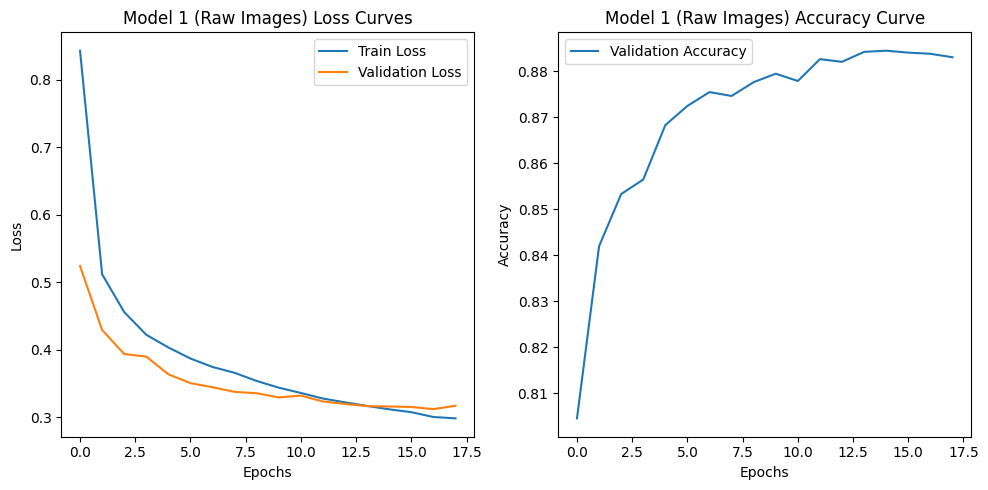

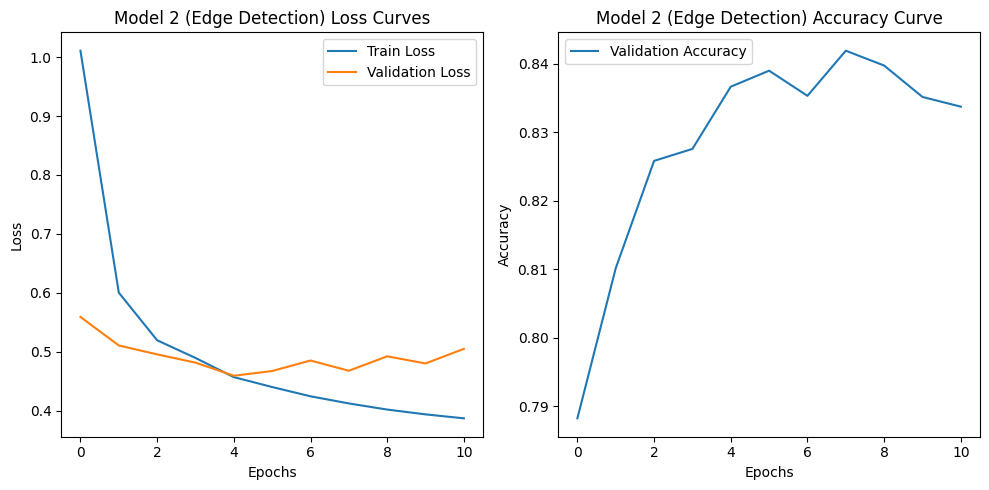

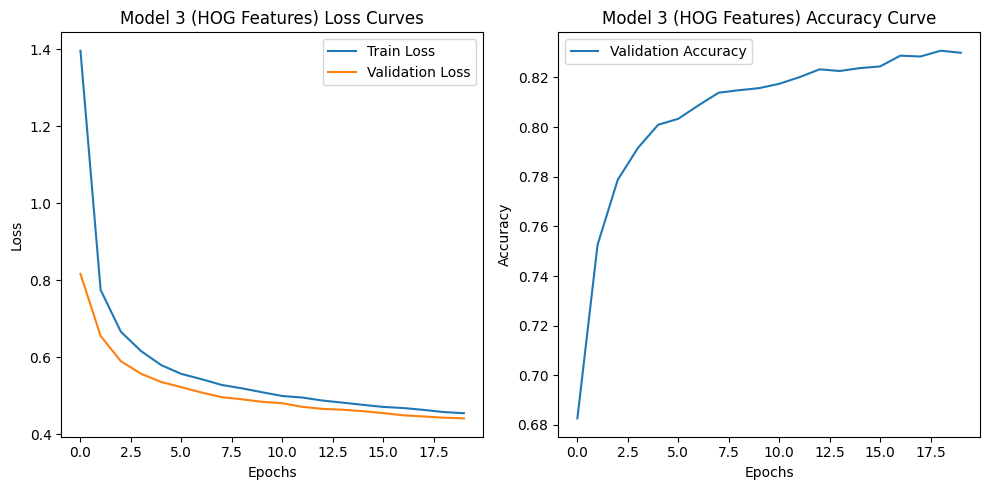

In [70]:
# Plot curves for each model
plot_training_curve(model1_train_loss, model1_val_loss, model1_val_acc, "Model 1 (Raw Images)")
plot_training_curve(model2_train_loss, model2_val_loss, model2_val_acc, "Model 2 (Edge Detection)")
plot_training_curve(model3_train_loss, model3_val_loss, model3_val_acc, "Model 3 (HOG Features)")


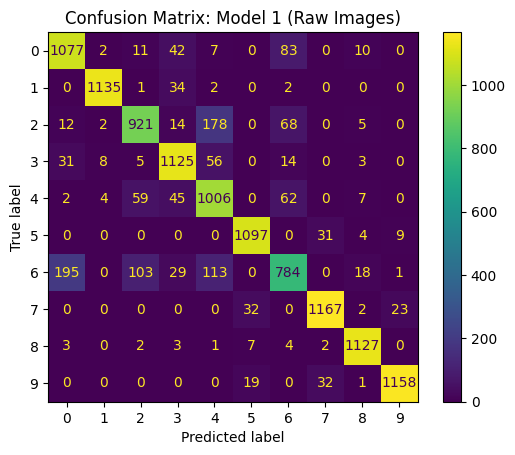

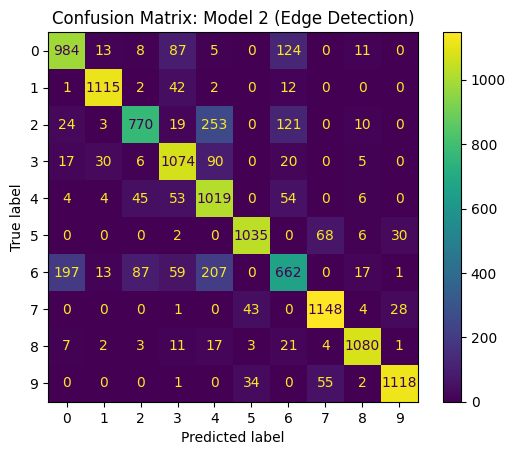

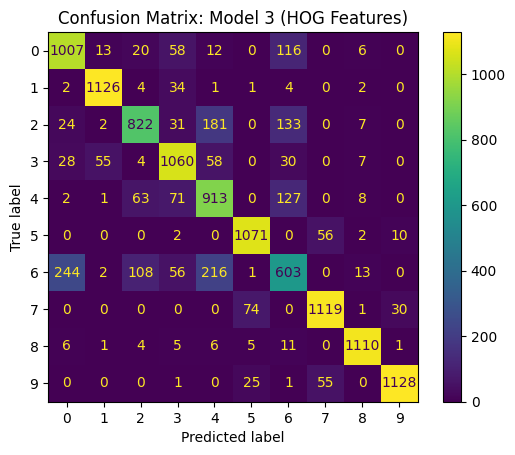

In [47]:
# Plot confusion matrices for each model
plot_confusion_matrix(model1, val_loader, "Confusion Matrix: Model 1 (Raw Images)")
plot_confusion_matrix(model2, edge_val_loader, "Confusion Matrix: Model 2 (Edge Detection)")
plot_confusion_matrix(model3, hog_val_loader, "Confusion Matrix: Model 3 (HOG Features)")

In [48]:
# Summarize and display performance
models = [model1, model2, model3]
loaders = [test_loader, canny_test_loader, hog_test_loader]
names = ["Model 1 (Raw Images)", "Model 2 (Edge Detection)", "Model 3 (HOG Features)"]
performance_summary = summarize_performance(models, loaders, names)

                      Model  Accuracy  Precision  Recall  F1-Score
0      Model 1 (Raw Images)    0.8846   0.884478  0.8846  0.883055
1  Model 2 (Edge Detection)    0.8379   0.841765  0.8379  0.835975
2    Model 3 (HOG Features)    0.8438   0.842124  0.8438  0.841571


In [72]:
def visualize_misclassified_images(model, loader, num_images=10):
    """Visualizes misclassified images.

    Args:
        model: The trained PyTorch model.
        loader: The data loader for the dataset.
        num_images: The number of misclassified images to display.
    """

    model.eval()  # Set the model to evaluation mode
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Find misclassified images
            misclassified_indices = (preds != labels).nonzero()
            for index in misclassified_indices:
                misclassified_images.append(images[index[0]].cpu().numpy())
                true_labels.append(labels[index[0]].cpu().item())
                predicted_labels.append(preds[index[0]].cpu().item())

            if len(misclassified_images) >= num_images:
                break

    # Display misclassified images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(misclassified_images[i].squeeze(), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

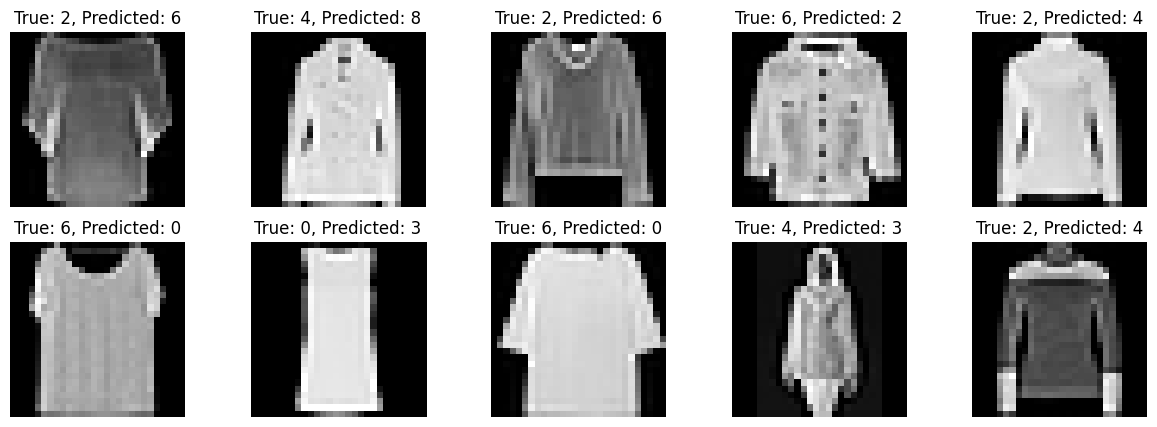

In [73]:
visualize_misclassified_images(model1, test_loader)

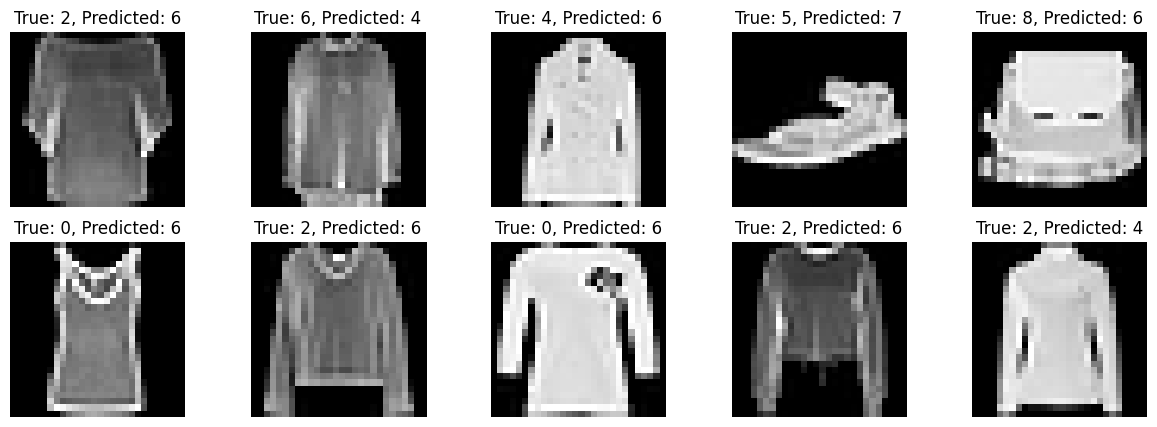

In [76]:
def visualize_misclassified_images(model, feature_loader, original_loader, num_images=10):
    model.eval()
    misclassified_original_images = []
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for (feature_images, labels), (original_images, _) in zip(feature_loader, original_loader):
            feature_images, labels = feature_images.to(device), labels.to(device)
            outputs = model(feature_images)
            _, preds = torch.max(outputs, 1)

            misclassified_indices = (preds != labels).nonzero()
            for index in misclassified_indices:
                misclassified_original_images.append(original_images[index[0]].cpu().numpy())
                true_labels.append(labels[index[0]].cpu().item())
                predicted_labels.append(preds[index[0]].cpu().item())

            if len(misclassified_original_images) >= num_images:
                break

    # Display misclassified images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(misclassified_original_images[i].squeeze(), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

# Call the function for Model 2 (Canny Edge Detection)
visualize_misclassified_images(model2, canny_test_loader, test_loader)


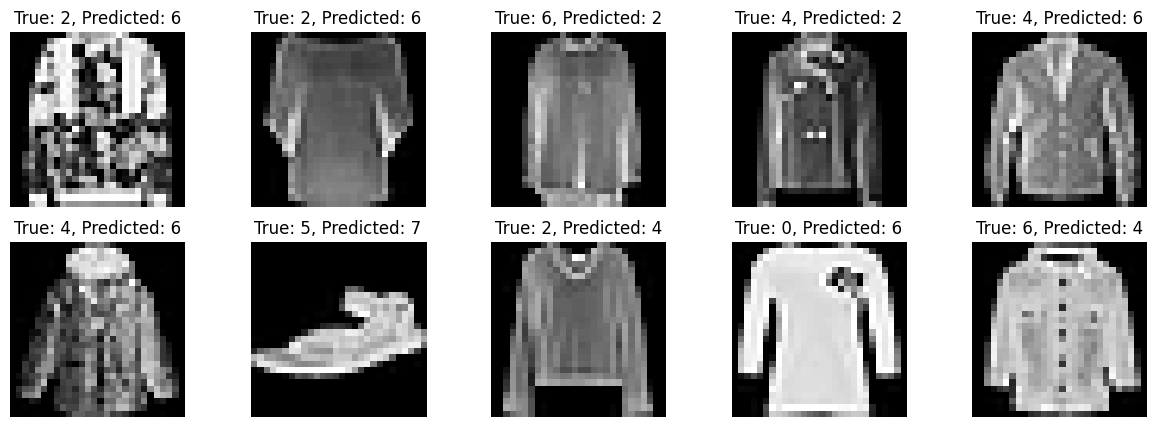

In [77]:

# Call the function for Model 3 (HOG Features)
visualize_misclassified_images(model3, hog_test_loader, test_loader)

Key Confusions:

- T-shirt/Top (0): Often misclassified as Shirt (6), as these categories have significant visual similarity in texture and shape.

- Pullover (2): Frequently misclassified as Coat (4) and Shirt (6). These errors likely stem from overlapping features like long sleeves and similar structural appearances.

- Shirt (6):Confused with T-shirt/Top (0) and Pullover (2), reflecting shared features like fabric folds and patterns.

- Sandal (5):Misclassified as Sneaker (7), as both can share overlapping silhouettes. Differences in sole details might not be captured well by feature extraction.

- Bag (8): Rarely confused, but slight errors with Sandal (5) and Ankle Boot (9) may arise from their similar spatial arrangements in certain orientations.

- Ankle Boot (9):Occasionally misclassified as Sneaker (7), likely due to overlapping shape features like soles.

Observations:

- The confusions largely occur in categories with high intra-class similarity (e.g., T-shirt vs. Shirt, Pullover vs. Coat).

- Edge detection and HOG features may amplify these challenges by losing subtle texture and material details, leading to more significant overlaps in misclassifications.


## 4.4 Analysis and Logical Comparison

1. Performance Differences Between Models:

	•Model 1 (Raw Images) achieved the highest accuracy (88.46%), suggesting that raw pixel data retained the most detailed information for classification.

	•Model 2 (Edge Detection) had lower accuracy (83.79%), indicating that edge features alone might discard critical details necessary for distinguishing similar classes like T-shirts and tops.

	•Model 3 (HOG Features) performed slightly better than edge detection (84.38%), showing that HOG captures useful structural patterns but may still lose fine-grained details.

	•Observation: Raw features are more helpful overall, but feature-engineered inputs like HOG can perform well in scenarios with strong shape-based distinctions.

2. Impact of Feature Extraction on MLP Learning and Generalization
	•Raw Images: Provide the most comprehensive input, enabling the MLP to learn nuanced patterns. However, they may require more data and computational resources to generalize well.

	•Edge Detection: Simplifies the input, highlighting boundaries. This is useful for classes distinguishable by outlines but struggles with subtle differences (e.g., T-shirts vs. tops).

	•HOG Features: Offer a balance by capturing structural details and gradients. They work well in scenarios where texture and shapes are crucial (e.g., sandals vs. purses).

	•Generalization: While feature extraction reduces input complexity, it may lead to loss of critical details, impacting the MLP’s ability to handle visually similar classes.

Final Observation on Mistakes

All models exhibit similar misclassification patterns (e.g., T-shirt vs. top, sandals vs. purses), indicating these errors arise from intrinsic similarities in the dataset rather than feature selection alone. Advanced methods like combining features or using CNNs might address these limitations.